In [1]:
!pip install keras==2.2.0

    100% |████████████████████████████████| 307kB 19.3MB/s ta 0:00:01
    100% |████████████████████████████████| 51kB 27.7MB/s ta 0:00:01
tensorflow 1.13.1 has requirement keras-applications>=1.0.6, but you'll have keras-applications 1.0.2 which is incompatible.
tensorflow 1.13.1 has requirement keras-preprocessing>=1.0.5, but you'll have keras-preprocessing 1.0.1 which is incompatible.
  Found existing installation: Keras-Applications 1.0.7
    Uninstalling Keras-Applications-1.0.7:
      Successfully uninstalled Keras-Applications-1.0.7
  Found existing installation: Keras-Preprocessing 1.0.9
    Uninstalling Keras-Preprocessing-1.0.9:
      Successfully uninstalled Keras-Preprocessing-1.0.9
  Found existing installation: Keras 2.2.4
    Uninstalling Keras-2.2.4:
      Successfully uninstalled Keras-2.2.4
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
from __future__ import print_function, division

from keras.applications.vgg19 import VGG19
from keras.layers import Input, Dense, Flatten, Dropout, Reshape
from keras.layers import BatchNormalization, Activation, Conv2D, Conv2DTranspose
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from keras.optimizers import Adam
from keras import models
from keras import layers
from keras import optimizers

from keras.datasets import cifar10
import keras.backend as K
import tensorflow as tf
from tensorflow.python.keras import backend as K
from keras.models import load_model

import matplotlib.pyplot as plt

import sys
import numpy as np

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
!pip install keras_vggface

    100% |████████████████████████████████| 51kB 11.2MB/s ta 0:00:01
    100% |████████████████████████████████| 51kB 26.0MB/s ta 0:00:01
  Stored in directory: /tmp/.cache/pip/wheels/72/aa/01/eb7baeb2f6e2d2f0d2aabddb5f01d57fa22fbd019ee2799bf5
Successfully built keras-vggface
keras 2.2.0 has requirement keras-applications==1.0.2, but you'll have keras-applications 1.0.8 which is incompatible.
keras 2.2.0 has requirement keras-preprocessing==1.0.1, but you'll have keras-preprocessing 1.1.0 which is incompatible.
  Found existing installation: Keras-Preprocessing 1.0.1
    Uninstalling Keras-Preprocessing-1.0.1:
      Successfully uninstalled Keras-Preprocessing-1.0.1
  Found existing installation: Keras-Applications 1.0.2
    Uninstalling Keras-Applications-1.0.2:
      Successfully uninstalled Keras-Applications-1.0.2
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
from keras_applications.imagenet_utils import _obtain_input_shape 


In [6]:
from keras_vggface import VGGFace

In [7]:
  vgg_model = VGGFace(include_top=False, input_shape=(64, 64, 3))
  vgg_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
58916864/58909280 [==============================] - 2s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 64, 64, 64)        1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 64, 64, 64)        36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 32, 32, 128)       147584    
_____

In [ ]:
  #vgg_model = VGG19(weights = "imagenet",include_top=False, input_shape=(64, 64, 3))

  #t=15
  #while t>0:
    #vgg_model.layers.pop()
    #t=t-1
  #vgg_model.summary()

In [33]:
def get_generator(input_layer):
 
  hid = Dense(128 * 32 * 32, activation='relu')(input_layer)    
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)
  hid = Reshape((32, 32, 128))(hid)

  hid = Conv2D(128, kernel_size=5, strides=1,padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)    
  #hid = Dropout(0.5)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2DTranspose(128, 4, strides=2, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2DTranspose(128, 4, strides=2, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2D(128, kernel_size=5, strides=1, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  #hid = Dropout(0.5)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2D(128, kernel_size=5, strides=1, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)
                      
  hid = Conv2D(3, kernel_size=5, strides=1, padding="same")(hid)
  out = Activation("tanh")(hid)

  model = Model(input_layer, out)
  model.summary()
  
  return model, out

In [34]:
def get_discriminator(input_layer):
  '''
  Requires the input layer as input, outputs the model and the final layer
  '''
  vgg_model = VGGFace(include_top=False, input_shape=(128, 128, 3))
  nb_class = 1
  hidden_dim = 512
  for layer in vgg_model.layers[:9]:
    layer.trainable=False
  last_layer = vgg_model.output
  x = Flatten(name='flatten')(last_layer)
  x = Dense(hidden_dim,name='fc6')(x)
  x = LeakyReLU(alpha=0.1)(x)
  #x = Dense(128,name='fc7')(x)
  #x = LeakyReLU(alpha=0.1)(x)
  out = Dense(nb_class, activation='sigmoid', name='fc8')(x)  

  model = Model(vgg_model.input, out)

  model.summary()

  return model, out

In [35]:
from keras.preprocessing import image

def generate_noise(n_samples, noise_dim):
  X = np.random.normal(0, 1, size=(n_samples, noise_dim))
  return X

def show_imgs(batchidx):
  noise = generate_noise(9, 100)
  gen_imgs = generator.predict(noise)

  fig, axs = plt.subplots(3, 3)
  count = 0
  for i in range(3):
    for j in range(3):
      img = image.array_to_img(gen_imgs[count], scale=True)
      axs[i,j].imshow(img)
      axs[i,j].axis('off')
      count += 1
  plt.show()
  plt.close()

In [36]:
# GAN creation
img_input = Input(shape=(128,128,3))
discriminator, disc_out = get_discriminator(img_input)
discriminator.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])

discriminator.trainable = False

noise_input = Input(shape=(100,))
generator, gen_out = get_generator(noise_input)

gan_input = Input(shape=(100,))
x = generator(gan_input)
gan_out = discriminator(x)
gan = Model(gan_input, gan_out)
gan.summary()

gan.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 128, 128, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 128, 128, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 64, 64, 64)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 64, 64, 128)       73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 64, 64, 128)       147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 32, 32, 128)       0         
__________

In [37]:
import os

In [13]:
# Data
BASE_PATH = "../input/celebrities-100k/"
print(os.listdir(BASE_PATH))
#BASE_PATH = base_PATH+ 'celebrities-100k' 
DATASET_LIST_PATH= BASE_PATH + "100k.txt"
print(DATASET_LIST_PATH)



['100k', '100k.txt']
../input/celebrities-100k/100k.txt


In [14]:
DATASET_LIST_PATH


'../input/celebrities-100k/100k.txt'

In [15]:
INPUT_DATA_DIR = BASE_PATH + "100k/100k/"


In [16]:
INPUT_DATA_DIR

'../input/celebrities-100k/100k/100k/'

In [17]:
OUTPUT_DIR = "./"


In [18]:
#MODEL_PATH = BASE_PATH + "models/" + "model_" + str(EPOCH) + ".ckpt"
DATASET = [INPUT_DATA_DIR + str(line).rstrip() for line in open(DATASET_LIST_PATH,"r")]

In [19]:
len(DATASET)

100000

In [20]:
data=DATASET[:10000]

In [21]:
#model_path = '../input/facenet-keras/facenet_keras.h5'
#facenet = load_model(model_path)

In [22]:
#facenet.summary()

In [23]:
import scipy.misc
import scipy.ndimage

In [24]:
#uploading images from folder
images = []
for img_name in data:
    image = scipy.ndimage.imread(img_name, mode="RGB")
    image_resized = scipy.misc.imresize(image,(128,128))
    images.append(image_resized)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


In [25]:
train_x = np.stack(images)

In [26]:
train_x.shape

(10000, 128, 128, 3)

In [27]:
X_train = train_x

In [28]:
X_train = ((X_train)-127.5)/127.5

In [29]:
BATCH_SIZE = 64

# # Get training images
#(X_train, y_train), (X_test, _) = cifar10.load_data()

# S

# Normalize data
 
num_batches = int(X_train.shape[0]/BATCH_SIZE)

In [30]:
X_train.shape

(10000, 128, 128, 3)

In [31]:
import time

/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:478: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


  Epoch: 1, Generator Loss: 1.4623949323327115, Discriminator Loss: [0.6074219 0.       ]


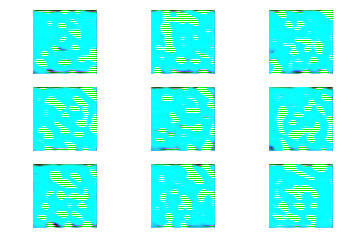

For epoch: 1, Time taken is: 132.43488430976868 seconds
  Epoch: 2, Generator Loss: 1.8018929404325974, Discriminator Loss: [0.36294904 0.        ]


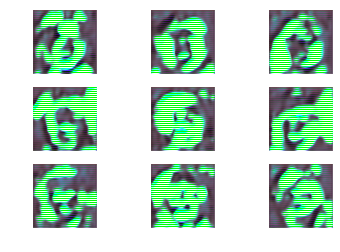

For epoch: 2, Time taken is: 125.50117826461792 seconds
  Epoch: 3, Generator Loss: 2.121668124046081, Discriminator Loss: [0.3528836 0.       ]


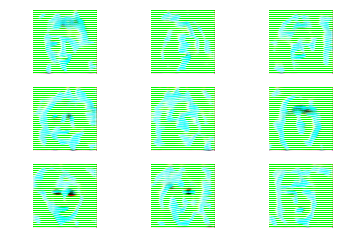

For epoch: 3, Time taken is: 125.46821761131287 seconds
  Epoch: 4, Generator Loss: 2.3856963775096793, Discriminator Loss: [0.34120744 0.        ]


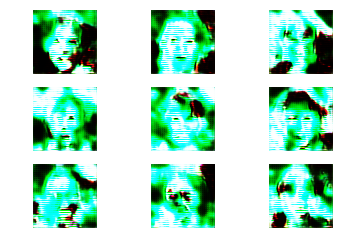

For epoch: 4, Time taken is: 125.43534994125366 seconds
  Epoch: 5, Generator Loss: 2.3492056597501803, Discriminator Loss: [0.35435513 0.        ]


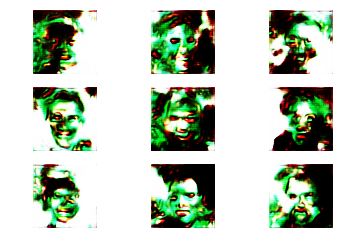

For epoch: 5, Time taken is: 125.38795351982117 seconds
  Epoch: 6, Generator Loss: 2.364365333165878, Discriminator Loss: [0.3620837 0.       ]


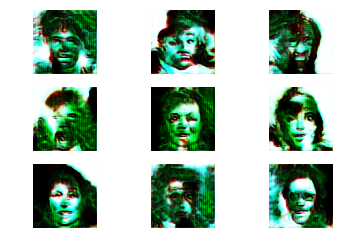

For epoch: 6, Time taken is: 125.35634160041809 seconds
  Epoch: 7, Generator Loss: 2.347417022173221, Discriminator Loss: [0.34562966 0.        ]


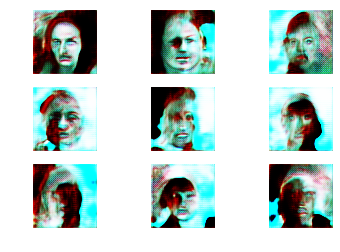

For epoch: 7, Time taken is: 125.41501450538635 seconds
  Epoch: 8, Generator Loss: 2.35149132899749, Discriminator Loss: [0.35622814 0.        ]


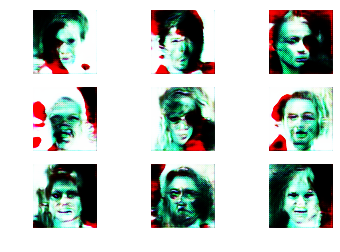

For epoch: 8, Time taken is: 125.41525220870972 seconds
  Epoch: 9, Generator Loss: 2.3681546380886664, Discriminator Loss: [0.35538962 0.        ]


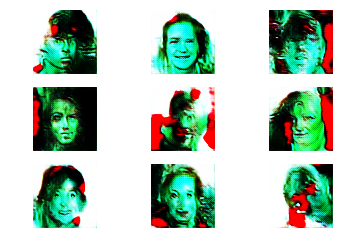

For epoch: 9, Time taken is: 125.44451308250427 seconds
  Epoch: 10, Generator Loss: 2.3360695105332594, Discriminator Loss: [0.35970068 0.        ]


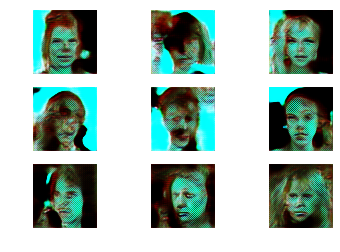

For epoch: 10, Time taken is: 125.42911171913147 seconds
  Epoch: 11, Generator Loss: 2.348752279312183, Discriminator Loss: [0.36038178 0.        ]


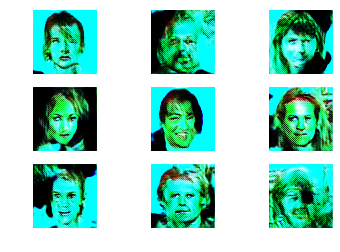

For epoch: 11, Time taken is: 125.42512607574463 seconds
  Epoch: 12, Generator Loss: 2.296509474515915, Discriminator Loss: [0.37231827 0.        ]


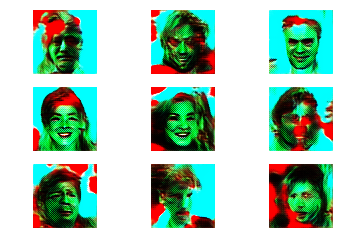

For epoch: 12, Time taken is: 125.27817916870117 seconds
  Epoch: 13, Generator Loss: 2.3066001060681467, Discriminator Loss: [0.36725882 0.        ]


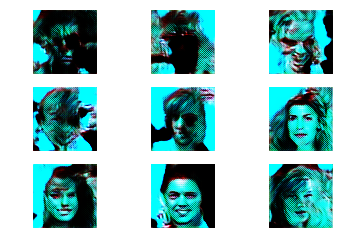

For epoch: 13, Time taken is: 125.4642813205719 seconds
  Epoch: 14, Generator Loss: 2.270588423197086, Discriminator Loss: [0.36102328 0.        ]


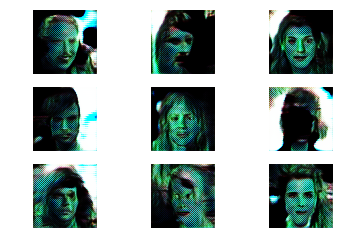

For epoch: 14, Time taken is: 125.61459517478943 seconds
  Epoch: 15, Generator Loss: 2.3023801621718283, Discriminator Loss: [0.35075107 0.        ]


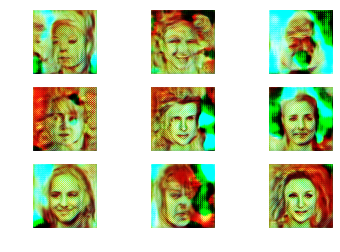

For epoch: 15, Time taken is: 125.71873450279236 seconds
  Epoch: 16, Generator Loss: 2.317923592451291, Discriminator Loss: [0.3624452 0.       ]


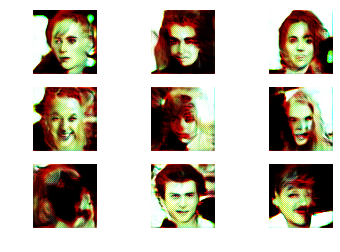

For epoch: 16, Time taken is: 125.85896825790405 seconds
  Epoch: 17, Generator Loss: 2.3086619759217286, Discriminator Loss: [0.35746053 0.        ]


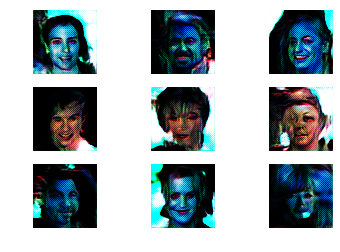

For epoch: 17, Time taken is: 125.79174613952637 seconds
  Epoch: 18, Generator Loss: 2.2715005530760837, Discriminator Loss: [0.35622063 0.        ]


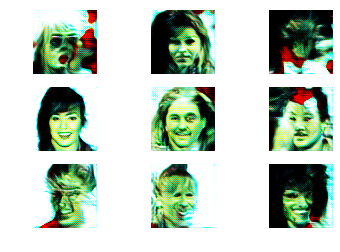

For epoch: 18, Time taken is: 125.61491537094116 seconds
  Epoch: 19, Generator Loss: 2.2512819308501024, Discriminator Loss: [0.35340634 0.        ]


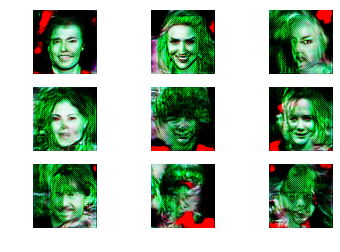

For epoch: 19, Time taken is: 125.41938638687134 seconds
  Epoch: 20, Generator Loss: 2.2980842796655803, Discriminator Loss: [0.3432623 0.       ]


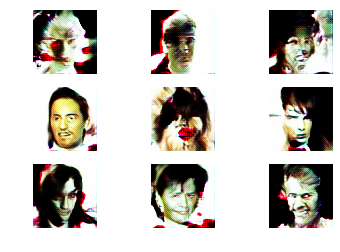

For epoch: 20, Time taken is: 125.34601855278015 seconds
  Epoch: 21, Generator Loss: 2.314813052996611, Discriminator Loss: [0.34532866 0.        ]


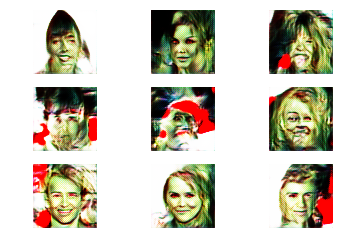

For epoch: 21, Time taken is: 125.38068127632141 seconds
  Epoch: 22, Generator Loss: 2.31933576021439, Discriminator Loss: [0.3492859 0.       ]


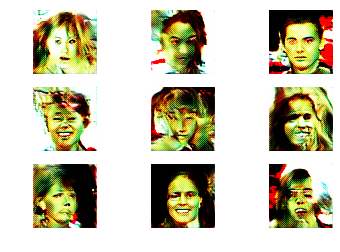

For epoch: 22, Time taken is: 125.32312846183777 seconds
  Epoch: 23, Generator Loss: 2.3263090764864898, Discriminator Loss: [0.35196006 0.        ]


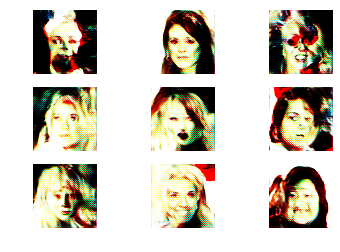

For epoch: 23, Time taken is: 125.31357026100159 seconds
  Epoch: 24, Generator Loss: 2.3187173375716577, Discriminator Loss: [0.34400508 0.        ]


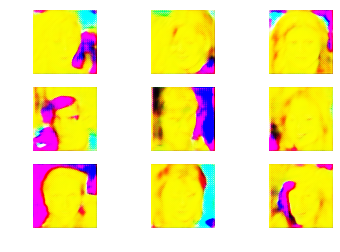

For epoch: 24, Time taken is: 125.31109142303467 seconds
  Epoch: 25, Generator Loss: 2.321475414893566, Discriminator Loss: [0.3366221 0.       ]


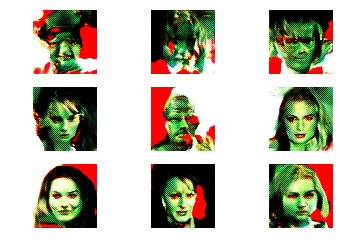

For epoch: 25, Time taken is: 125.12414741516113 seconds
  Epoch: 26, Generator Loss: 2.3034009551390624, Discriminator Loss: [0.3511841 0.       ]


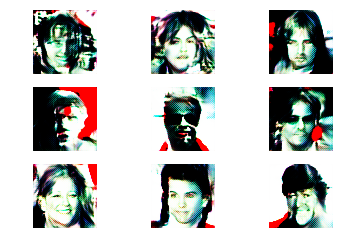

For epoch: 26, Time taken is: 125.15585255622864 seconds
  Epoch: 27, Generator Loss: 2.306123919211901, Discriminator Loss: [0.34604323 0.        ]


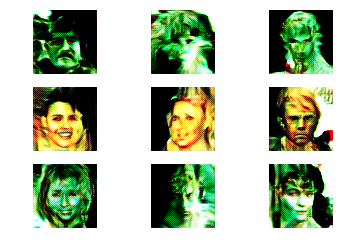

For epoch: 27, Time taken is: 125.14009809494019 seconds
  Epoch: 28, Generator Loss: 2.299897776964383, Discriminator Loss: [0.35067058 0.        ]


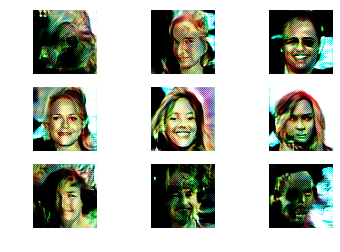

For epoch: 28, Time taken is: 125.11055898666382 seconds
  Epoch: 29, Generator Loss: 2.2809816812857604, Discriminator Loss: [0.34972247 0.        ]


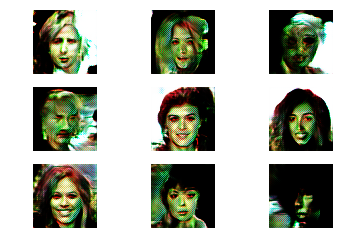

For epoch: 29, Time taken is: 125.11580443382263 seconds
  Epoch: 30, Generator Loss: 2.3169343020671453, Discriminator Loss: [0.3358957 0.       ]


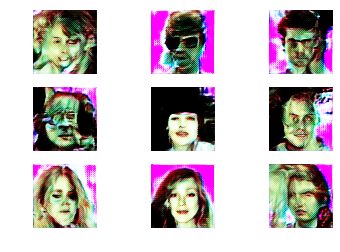

For epoch: 30, Time taken is: 125.27664685249329 seconds
  Epoch: 31, Generator Loss: 2.309407020990665, Discriminator Loss: [0.33841845 0.        ]


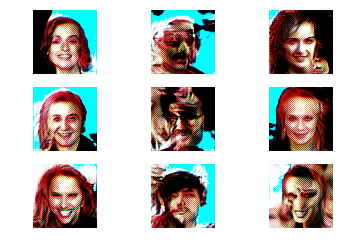

For epoch: 31, Time taken is: 125.5257260799408 seconds
  Epoch: 32, Generator Loss: 2.3144453779245033, Discriminator Loss: [0.33457348 0.        ]


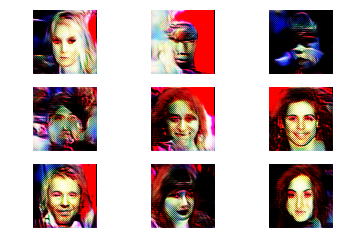

For epoch: 32, Time taken is: 125.14513659477234 seconds
  Epoch: 33, Generator Loss: 2.318115105231603, Discriminator Loss: [0.34270138 0.        ]


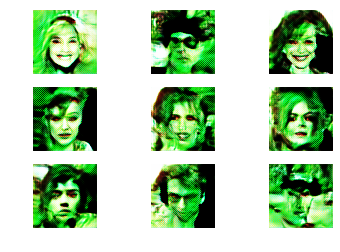

For epoch: 33, Time taken is: 125.12083411216736 seconds
  Epoch: 34, Generator Loss: 2.2969410770978684, Discriminator Loss: [0.3490634 0.       ]


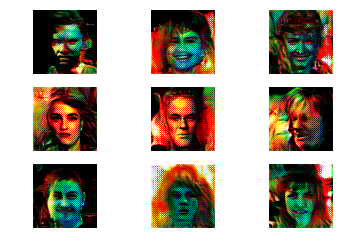

For epoch: 34, Time taken is: 125.09043645858765 seconds


KeyboardInterrupt: 

In [38]:
N_EPOCHS = 200
for epoch in range(N_EPOCHS):
  tic=time.time()
  cum_d_loss = 0.
  cum_g_loss = 0.
  
  for batch_idx in range(num_batches):
    # Get the next set of real images to be used in this iteration
    images = X_train[batch_idx*BATCH_SIZE : (batch_idx+1)*BATCH_SIZE]

    noise_data = generate_noise(BATCH_SIZE, 100)
    generated_images = generator.predict(noise_data)

    # Train on soft labels (add noise to labels as well)
    noise_prop = 0.05 # Randomly flip 5% of labels
    
    # Prepare labels for real data
    true_labels = np.zeros((BATCH_SIZE, 1)) + np.random.uniform(low=0.0, high=0.1, size=(BATCH_SIZE, 1))
    flipped_idx = np.random.choice(np.arange(len(true_labels)), size=int(noise_prop*len(true_labels)))
    true_labels[flipped_idx] = 1 - true_labels[flipped_idx]
    
    # Train discriminator on real data
    d_loss_true = discriminator.train_on_batch(images, true_labels)

    # Prepare labels for generated data
    gene_labels = np.ones((BATCH_SIZE, 1)) - np.random.uniform(low=0.0, high=0.1, size=(BATCH_SIZE, 1))
    flipped_idx = np.random.choice(np.arange(len(gene_labels)), size=int(noise_prop*len(gene_labels)))
    gene_labels[flipped_idx] = 1 - gene_labels[flipped_idx]
    
    # Train discriminator on generated data
    d_loss_gene = discriminator.train_on_batch(generated_images, gene_labels)

    d_loss = 0.5 * np.add(d_loss_true, d_loss_gene)
    cum_d_loss += d_loss
    # Train generator
    noise_data = generate_noise(BATCH_SIZE, 100)
    g_loss = gan.train_on_batch(noise_data, np.zeros((BATCH_SIZE, 1)))
    cum_g_loss += g_loss
    
  noise_data = generate_noise(BATCH_SIZE, 100)
  #generated_images = generator.predict(noise_data)
  print('  Epoch: {}, Generator Loss: {}, Discriminator Loss: {}'.format(epoch+1, cum_g_loss/num_batches, cum_d_loss/num_batches))
  show_imgs("epoch" + str(epoch))
  toc=time.time()
  print("For epoch: "+ str(epoch +1)+", Time taken is: " +str(toc-tic)+ " seconds")
  #print(discriminator.predict(generated_images))
